In [1]:
# Remember to cite knotinfo
# https://knotinfo.math.indiana.edu/homelinks/cite_info.html
import os
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
os.chdir('/Users/alexchandler/kr-calc/csv_files') #change to python script directory
knot_info = pd.read_csv('Knotinfo_data.csv', dtype='object')  

import sklearn
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
import itertools


# import required module for iterating through directory
import os
import json
# assign directory
os.chdir('/Users/alexchandler/kr-calc') #change to python script directory
directory = 'data'
#we create a dictionary with keys: names of knots
                          #values: dictionaries (keys: nonzero gradings, values: homology dimensions)
homfly_data={}
# sort directory and then iterate over files in that directory, creating a dictionary for easier use
listing = os.listdir(directory)
listing.sort()
for filename in listing:
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        with open(f) as json_file:
            data = json.load(json_file)
            data_dict = {}
            for i in range(int(len(data)/2)):
                data_dict[tuple(data[2*i])]=data[2*i+1]
            homfly_data[filename[:-5]]=data_dict
            
#import functions from functions.py (contains all functions being called in this notebook)
os.chdir('/Users/alexchandler/kr-calc/python_scripts') #change to python script directory
from functions import *

#creates two groups: planar and nonplanar
non_planar_knots = [knot for knot in list(homfly_data.keys()) 
                    if planar_support_alt(homfly_data[knot])>1]



In [11]:
homfly_data['8_19']

{(-6, 6, 6): 1,
 (-2, 6, 2): 1,
 (2, 6, -2): 1,
 (6, 6, -6): 1,
 (-2, 8, -2): 1,
 (2, 8, -6): 1,
 (-4, 8, 2): 1,
 (0, 8, -2): 1,
 (4, 8, -6): 1,
 (0, 6, -2): 1,
 (0, 10, -6): 1}

In [2]:
#gathered all possible knot invariants from knotinfo (saved as 'all_knotinfo.csv')
#turning it into a pandas dataframe

#gathered all possible knot invariants from knotinfo (saved as 'all_knotinfo.csv')
#turning it into a pandas dataframe
os.chdir('/Users/alexchandler/kr-calc/csv_files') #change to python script directory
knot_info = pd.read_csv('knotinfo_data_complete.csv') 


In [3]:
for col in knot_info.columns:
    print(col)

name
name_anon
diagram
diagram_anon
category
category_anon
knot_atlas
knot_atlas_anon
knotilus_page
knotilus_page_anon
alternating
alternating_anon
name_rank
name_rank_anon
dt_name
dt_name_anon
dt_rank
dt_rank_anon
dt_notation
dt_notation_anon
classical_conway_name
classical_conway_name_anon
conway_notation
conway_notation_anon
two_bridge_notation
two_bridge_notation_anon
fibered
fibered_anon
gauss_notation
gauss_notation_anon
enhanced_gauss_notation
enhanced_gauss_notation_anon
pd_notation
pd_notation_anon
crossing_number
crossing_number_anon
tetrahedral_census_name
tetrahedral_census_name_anon
unknotting_number
unknotting_number_anon
three_genus
three_genus_anon
crosscap_number
crosscap_number_anon
bridge_index
bridge_index_anon
braid_index
braid_index_anon
braid_length
braid_length_anon
braid_notation
braid_notation_anon
signature
signature_anon
nakanishi_index
nakanishi_index_anon
super_bridge_index
super_bridge_index_anon
thurston_bennequin_number
thurston_bennequin_number_anon
ar

In [4]:
def s_invariant(knot):
    result = knot_info.loc[knot_info['name'] == knot]['rasmussen_invariant'].values[0]
    return int(result)

R.<q,t>=PolynomialRing(QQ)
K=R.fraction_field()

def khovanov_homology(knot):
    poly = knot_info.loc[knot_info['name'] == knot]['khovanov_polynomial'].values[0]
    acceptables = ['+','-','*','(','^']
    variables=['q','t']
    while True:
        issuesvars = [i for i in range(len(poly)) if i>0 and (poly[i] in variables) 
                      and not (poly[i-1] in acceptables)]
        issuesnums = [i for i in range(len(poly)) if i>0 and (poly[i].isnumeric()) 
                      and not(poly[i-1].isnumeric()) and not (poly[i-1] in acceptables)]
        issues = issuesvars + issuesnums
        if len(issues)==0:
            break
        i = issues[0]
        poly1=poly[0:i]
        poly2=poly[i:]
        poly=poly1+'*'+poly2
        
    return K(poly).numerator().dict()

def khovanov_homology_torsion(knot):
    poly = knot_info.loc[knot_info['name'] == knot]['khovanov_torsion_polynomial'].values[0]
    poly = poly.replace("Q",'q')
    acceptables = ['+','-','*','(','^']
    variables=['q','t']
    while True:
        issuesvars = [i for i in range(len(poly)) if i>0 and (poly[i] in variables) 
                      and not (poly[i-1] in acceptables)]
        issuesnums = [i for i in range(len(poly)) if i>0 and (poly[i].isnumeric()) 
                      and not(poly[i-1].isnumeric()) and not (poly[i-1] in acceptables)]
        issues = issuesvars + issuesnums
        if len(issues)==0:
            break
        i = issues[0]
        poly1=poly[0:i]
        poly2=poly[i:]
        poly=poly1+'*'+poly2
    return K(poly).numerator().dict()

def reduced_khovanov_homology(knot):
    kh_dict=khovanov_homology(knot)
    print('not yet implemented... should be doable from the khovanov homology but I forget how')

#for planar knots we drop the z coordinate and plot just the xy and the value of the homology
def plot_khovanov(knot):  
    homology = khovanov_homology(knot)
    gradings = homology.keys()
    #making markers as ranks of homology groups
    markers=[]
    for grading in gradings:
        markers.append(homology[grading])
    xs = [grading[1] for grading in gradings]
    ys = [grading[0] for grading in gradings]
    #configuring the plot
    fig, ax = plt.subplots(1, 2, figsize=(10,10))
    #ax[0].scatter(xs, ys, s=1, c="white")
    # change default range
    ax[0].set_xlim((min(xs)-1, max(xs)+1))
    ax[0].set_ylim((min(ys)-1, max(ys)+1))
    #computing the signature
    base = list(gradings)[0]
    signature = str(-(base[0]+base[1]+base[2]))
    #setting the title
    ax[0].set(title='Khovanov Homology of '+knot+'\nRasmussen s-invariant: '+str(s_invariant(knot)), 
              aspect=.5, xticks=range(min(xs)-1, max(xs)+2), yticks=range(min(ys), max(ys)+2,2))
    #setting xscale and yscale to be equal
    plt.gca().set_aspect(.5, adjustable='box')
    #circling gradings containing d1 and dm1 homology

    #making colors depending on size of homology
    colors=[]
    for txt in markers:
        if txt%6==1:
            colors.append("black")
        elif txt%6==2:
            colors.append("blue")
        elif txt%6==3:
            colors.append("green")
        elif txt%6==4:
            colors.append("red")
        elif txt%6==5:
            colors.append("purple")
        elif txt%6==0:
            colors.append("orange")
    #drawing the ranks of homology groups over top of invisible dots
    for i, txt in enumerate(markers):
        text_kwargs = dict(ha='center', va='center', fontsize=20, color=colors[i])
        ax[0].text(xs[i], ys[i], txt, **text_kwargs)
        #ax[0].annotate(txt, xy=(xs[i], ys[i]),xytext=(xs[i]-0.3, ys[i]-0.4),fontsize=20, c=colors[i])
    #showing image of knot
    ax[1].set(title=knot, aspect=1, xticks=[], yticks=[])
    img = mpimg.imread('diagrams/'+knot+'.png')
    imgplot = ax[1].imshow(img)
    #plt.show()


#plt.plot(xs, ys, markers)
#for x, y in zip(xs, ys):
    #plt.text(x, y, markers, color="black", fontsize=12)
    
#for planar knots we drop the z coordinate and plot just the xy and the value of the homology
def plot_khovanov_torsion(knot):  
    homology = khovanov_homology_torsion(knot)
    gradings = homology.keys()
    #making markers as ranks of homology groups
    markers=[]
    for grading in gradings:
        markers.append(homology[grading])
    xs = [grading[1] for grading in gradings]
    ys = [grading[0] for grading in gradings]
    #configuring the plot
    fig, ax = plt.subplots(1, 2, figsize=(10,10))
    #ax[0].scatter(xs, ys, s=1, c="white")
    # change default range
    ax[0].set_xlim((min(xs)-1, max(xs)+1))
    ax[0].set_ylim((min(ys)-1, max(ys)+1))
    #computing the signature
    base = list(gradings)[0]
    signature = str(-(base[0]+base[1]+base[2]))
    #setting the title
    ax[0].set(title='Khovanov Homology of '+knot+'\nRasmussen s-invariant: '+str(s_invariant(knot)), 
              aspect=.5, xticks=range(min(xs)-1, max(xs)+2), yticks=range(min(ys), max(ys)+2,2))
    #setting xscale and yscale to be equal
    plt.gca().set_aspect(.5, adjustable='box')
    #circling gradings containing d1 and dm1 homology

    #making colors depending on size of homology
    colors=[]
    for txt in markers:
        if txt%6==1:
            colors.append("black")
        elif txt%6==2:
            colors.append("blue")
        elif txt%6==3:
            colors.append("green")
        elif txt%6==4:
            colors.append("red")
        elif txt%6==5:
            colors.append("purple")
        elif txt%6==0:
            colors.append("orange")
    #drawing the ranks of homology groups over top of invisible dots
    for i, txt in enumerate(markers):
        text_kwargs = dict(ha='center', va='center', fontsize=20, color=colors[i])
        ax[0].text(xs[i], ys[i], txt, **text_kwargs)
        #ax[0].annotate(txt, xy=(xs[i], ys[i]),xytext=(xs[i]-0.3, ys[i]-0.4),fontsize=20, c=colors[i])
    #showing image of knot
    ax[1].set(title=knot, aspect=1, xticks=[], yticks=[])
    img = mpimg.imread('diagrams/'+knot+'.png')
    imgplot = ax[1].imshow(img)
    #plt.show()


#plt.plot(xs, ys, markers)
#for x, y in zip(xs, ys):
    #plt.text(x, y, markers, color="black", fontsize=12)



In [5]:
reduced_khovanov_homology('8_19')

not yet implemented... should be doable from the khovanov homology but I forget how


FileNotFoundError: [Errno 2] No such file or directory: 'diagrams/8_19.png'

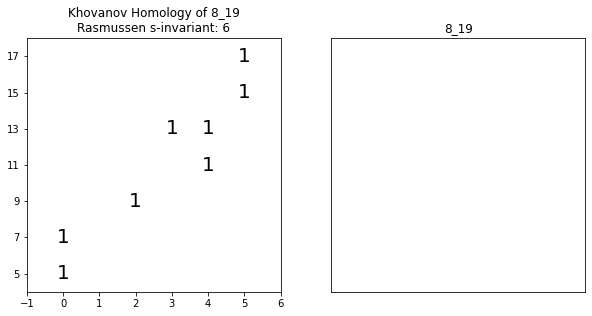

In [6]:
plot_khovanov('8_19')

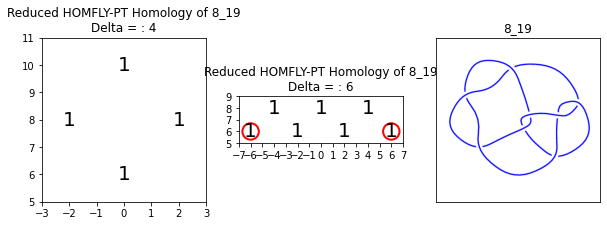

In [10]:
plot_homology_nonplanar('8_19')

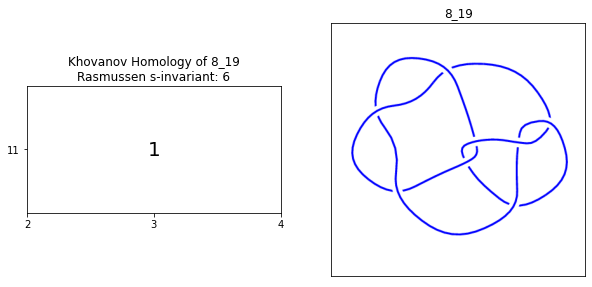

In [9]:
plot_khovanov_torsion('8_19')

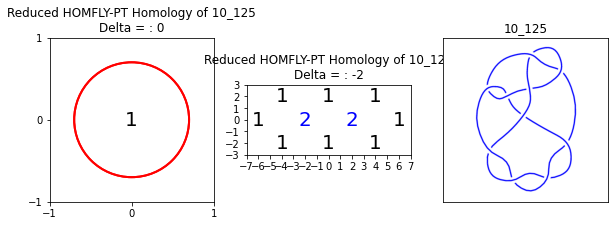

In [12]:
plot_homology_nonplanar('10_125')

In [9]:
khovanov_homology('3_1')

{(8, 3): 1, (6, 3): 1, (4, 1): 1, (0, 0): 1}

In [11]:
khovanov_homology_torsion('3_1')

{(0, 0): 1}

In [13]:
poly = knot_info.loc[knot_info['name'] == '3_1']['khovanov_torsion_polynomial'].values[0];poly

'Q^(-7)t^(-2)'

In [78]:
s_invariant('5_1')

4

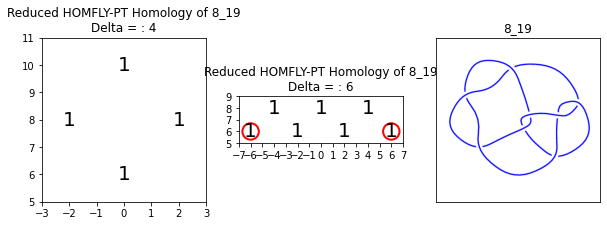

In [79]:
plot_homology_nonplanar('8_19')

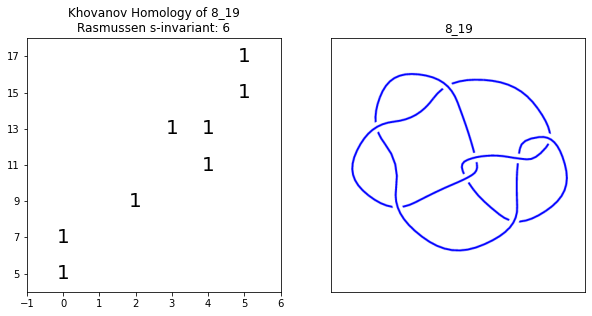

In [80]:
plot_khovanov('8_19')

In [97]:
hom = khovanov_homology('8_1');hom

{(18, 8): 1,
 (14, 7): 1,
 (14, 6): 2,
 (12, 6): 1,
 (12, 5): 1,
 (10, 5): 1,
 (10, 4): 1,
 (8, 4): 1,
 (8, 3): 1,
 (6, 3): 1,
 (4, 2): 1,
 (4, 1): 1,
 (0, 0): 1}

In [ ]:
def reduced_khovanov_homology(knot):
    kh = khovanov_homology(knot);
    for key in kh.keys():
        

In [84]:
hom = khovanov_homology_torsion('8_1');hom


{(14, 7): 1, (10, 5): 1, (8, 4): 1, (6, 3): 1, (4, 2): 1, (0, 0): 1}

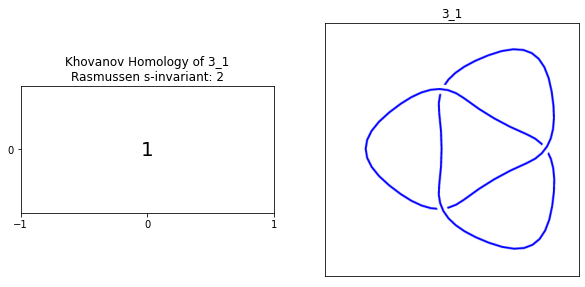

In [87]:
plot_khovanov_torsion('3_1')

In [69]:
knot='3_1'
poly=knot_info.loc[knot_info['name'] == knot]['khovanov_polynomial'].values[0]
poly

'q^(-9)t^(-3)+q^(-5)t^(-2)+q^(-3)+q^(-1)'

In [64]:
R.<q,t>=PolynomialRing(QQ)
K=R.fraction_field()

In [93]:
knot='3_1'
knot_info.loc[knot_info['name'] == knot]['khovanov_torsion_polynomial'].values[0]

'Q^(-7)t^(-2)'

In [98]:
B = BraidGroup(5)
K = Knot(B([1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4]))

In [100]:
K.khovanov_homology(ring=QQ,height=0,degree=0)

KeyboardInterrupt: 

In [16]:
def remove_Gs_from_end(string):
    i=len(string)-1
    while string[i]=='G':
        i-=1
    return string[:i+1]

remove_Gs_from_end("ATCTCTGTGTGTAGTGTCGTGATGGCTGTAGGCTGAGTCGGTAGGCGGGGGGGGGGGGG")

'ATCTCTGTGTGTAGTGTCGTGATGGCTGTAGGCTGAGTCGGTAGGC'

In [40]:
atcg_dict={0:"A",1:"T",2:"C",3:"G"}
#build long string
string=''
stringbad=''
for i in range(150):
    string+=atcg_dict[randint(0,3)]
#remove last 50 elements and replace with 50 G's
stringbad=string[0:100]+'G'*50
#remove all Gs at the end for 40 million strings
#only have bad strings for one in 20
def run_func_on_dataset():
    for i in range(40000000):
        if i%20==0:
            remove_Gs_from_end(stringbad)
        else:
            remove_Gs_from_end(string)

In [41]:
time run_func_on_dataset()

CPU times: user 34.9 s, sys: 53.6 ms, total: 35 s
Wall time: 35 s
